# 0 - Libraries to load up front

In [1]:
import numpy as np
from math import pi
try:
    from qiskit import *
    from matplotlib.pyplot import plot,show
except:
    ! python -m pip install matplotlib pylatexenc
    ! python -m pip install qiskit
from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import *
from qiskit.circuit.library import *
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.quantum_info.operators import Operator
from qiskit.extensions.simulator.snapshot import snapshot
from scipy import optimize
from matplotlib.pyplot import plot,show
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# 1 - Circuits

A circuit in QisKit acts on quantum *and* classical registers.

A classical register aims at storing the result of the measurement of a quantum register.

In [21]:
# Allocating 2 qubits
q = QuantumRegister(2, name="x")

# Allocating 2 bits
c = ClassicalRegister(2, name="y")

# We build a quantum circuit with both registers.
# By default, everything is initialized to 0 and to |0>
qc = QuantumCircuit(q,c)

# Applying Hadamard on qubit 0:
# qc.h(q[0])

# Applying X on qubit 0:
qc.h(q[0])
qc.h(q[1])
qc.cnot(q[0], q[1])
qc.h(q[0])
qc.h(q[1])

# Applying z on qubit 0:
# qc.z(q[0])

# # Applying CNOT on qubits 0 and 1:
# qc.cnot(q[0],q[1])

# Mesure of all of register q, storing results in c.
# This is still part of the circuit
# qc.measure(q[0], c[0])
qc.measure(q, c)
backend = BasicAer.get_backend('qasm_simulator')

# Then performs several runs of the circuit using this backend. Here we ask for 1024 runs.
job = execute(qc, backend, shots=1024)

# To retrieve the results -- note how we only get values for the single bit-register 
res = dict(job.result().get_counts(qc))

res

{'00': 1024}

The circuit can be drawn in text-style or with mathplotlib. Note how the name given to the registers appear on the drawing. The simple wires are qubit-wires, while the doubled-wires are for bits.

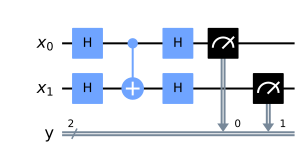

In [23]:
qc.draw("mpl")

# 2 - Runing a circuit 

One can run a circuit with **backends**.

Here is a backend emulating the behavior of a quantum co-processor. It makes it possible to *lauch* a series of runs, keeping track of how many of each results were obtained in the classical registers (remember, each run is probabilistic).

In [8]:
q = QuantumRegister(2, name="x")
c = ClassicalRegister(2, name="y") 

qc = QuantumCircuit(q,c)
qc.h(q[0])          # build a 
qc.cnot(q[0],q[1])  # Bell state

qc.measure(q[0], c[0]) # measure of all of q

# To run the circuit, we initialize a backend
backend = BasicAer.get_backend('qasm_simulator')

# Then performs several runs of the circuit using this backend. Here we ask for 1024 runs.
job = execute(qc, backend, shots=1024)

# To retrieve the results -- note how we only get values for the single bit-register 
res = dict(job.result().get_counts(qc))

res

{'01': 519, '00': 505}

In [9]:
qc.draw()

┌───┐     ┌─┐
x_0: ┤ H ├──■──┤M├
     └───┘┌─┴─┐└╥┘
x_1: ─────┤ X ├─╫─
          └───┘ ║ 
y_0: ═══════════╩═
                  
y_1: ═════════════

In what we just saw, we measured **all** of the system. The dictionary stores the number of times each key has been found with the final measure.

We can however measure only part of the system: the rest is "forgotten". For instance, in the following we only measure the 1st qubit

In [4]:
q = QuantumRegister(2, name="x")
c = ClassicalRegister(1, name="y")

qc = QuantumCircuit(q,c)
qc.h(q[0])          # on fabrique un 
qc.cnot(q[0],q[1])  # état de Bell


qc.measure(q[1], c[0]) # mesure du premier qubit

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
res = dict(job.result().get_counts(qc))
res

{'1': 520, '0': 504}

In [5]:
qc.draw()

┌───┐        
x_0: ┤ H ├──■─────
     └───┘┌─┴─┐┌─┐
x_1: ─────┤ X ├┤M├
          └───┘└╥┘
  y: ═══════════╩═

Note how the keys only contain one bit : the content of the classical register 


# 3 - Order of the bits in the keys

Unlike what we saw in class, the bit-vector has to be read "by turning the head on the left" with respect to the circuit: in a register $x$, the qubit $x_0$ (top wire) is the first one. This is also the case for the classical registers.

Below a concrete example:

In [9]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

# Applying X on qubit 0
qc.x(q[0])

# So at the end, |x_0 x_1> is in state |10>
qc.measure(q,c)

qc.draw()

# And now, in register c[0] we have 1 and in c[1] we have 0. 
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
dict(job.result().get_counts(qc))

{'01': 1024}

In [10]:
qc.draw()

┌───┐┌─┐
q9_0: ┤ X ├┤M├
      └┬─┬┘└╥┘
q9_1: ─┤M├──╫─
       └╥┘  ║ 
c0_0: ══╬═══╩═
        ║     
c0_1: ══╩═════

A key should then be read $b_1b_0$ : the register $c$ is written "$c_1c_0$".

# 4 - Boxing : unitaries and sub-circuits

It is possible to look at a sub-circuit as a unitary gate. This circuit can then be used as many time as needed in another circuit.

Beware: only circuits **without** classical registers can be boxed into a unitary gate...

In [6]:
# Let us build a circuit

q = QuantumRegister(2, name="x")
aux = QuantumCircuit(q) # No classical registers !
aux.h(q[0])
aux.cnot(q[0],q[1])

aux.draw()

┌───┐     
x_0: ┤ H ├──■──
     └───┘┌─┴─┐
x_1: ─────┤ X ├
          └───┘

In [7]:
# We can now make a home-made gate using this circuit

o = aux.to_gate(label="moncirc") # name to be used in drawings

In [8]:
# We now have a new gate "o" acting on 2 qubits. We can use it as we want.

q = QuantumRegister(4, name="x")
qc = QuantumCircuit(q)

qc.barrier()  # To horizontally "separate" pieces of circuits, in drawings for instance.
qc.append(o,[q[0],q[1]]) # adding an object "UnitaryGate" can be done with .append
qc.barrier()
qc.append(o,[q[2],q[1]]) # Check the numbering in the drawing !
qc.barrier()
qc.append(o.control(),[q[0],q[2],q[3]]) # We can control a door -- the first wire is the control qubit.

qc.draw()


░ ┌──────────┐ ░              ░             
x_0: ─░─┤0         ├─░──────────────░──────■──────
      ░ │  moncirc │ ░ ┌──────────┐ ░      │      
x_1: ─░─┤1         ├─░─┤1         ├─░──────┼──────
      ░ └──────────┘ ░ │  moncirc │ ░ ┌────┴─────┐
x_2: ─░──────────────░─┤0         ├─░─┤0         ├
      ░              ░ └──────────┘ ░ │  moncirc │
x_3: ─░──────────────░──────────────░─┤1         ├
      ░              ░              ░ └──────────┘

In [17]:
# One can open the boxes

qc.decompose().draw()

# Note how the controlled gate is splitted into native, elementary gates on 1 and 2 qubits.

░ ┌───┐      ░            ░                      
x_0: ─░─┤ H ├──■───░────────────░────────■──────────■──
      ░ └───┘┌─┴─┐ ░      ┌───┐ ░        │          │  
x_1: ─░──────┤ X ├─░──────┤ X ├─░────────┼──────────┼──
      ░      └───┘ ░ ┌───┐└─┬─┘ ░ ┌──────┴───────┐  │  
x_2: ─░────────────░─┤ H ├──■───░─┤ U(π/2,0,π,0) ├──■──
      ░            ░ └───┘      ░ └──────────────┘┌─┴─┐
x_3: ─░────────────░────────────░─────────────────┤ X ├
      ░            ░            ░                 └───┘

# 5 - High-level operations on UnitaryGate

Once we have a UnitaryGate object (for instance the 'o' object), one can perform various operations in it, such as
* power
* control
* inverse

However, the names get all mangled...

Below some examples

In [2]:
q = QuantumRegister(4, name="x")
qc = QuantumCircuit(q)

qc.append(o.power(2),[q[0],q[1]]) # will perform 'o' twice

qc.append(o.power(5).control().control(),[q[2],q[3],q[0],q[1]]) # power and control can be combined 

qc.append(o.inverse(),[q[0],q[1]]) # for the inverse (the _dg in the name stands for "dagger")

qc.append(o.control(num_ctrl_qubits=2, ctrl_state='10'),[q[2],q[3],q[0],q[1]]) 
    # one can perform a bunch of positive and negative controls in one go.
          
qc.draw()

# Ugly names ! But the name somehow keep the power so we know where it comes from.

NameError: name 'o' is not defined

In [16]:
qc.decompose().draw()

global phase: 7π/4
       ┌──────────────────┐      ┌───────────────────┐                       »
x_0: ──┤ U3(π/2,π/2,-π/2) ├───■──┤ U3(π/2,-π/2,-π/2) ├────────────────────■──»
     ┌─┴──────────────────┴┐┌─┴─┐├───────────────────┴┐                   │  »
x_1: ┤ U3(0.84804,π/2,π/2) ├┤ X ├┤ U3(2.4188,π/2,π/2) ├───────────────────┼──»
     └───┬─────────────┬───┘└───┘└────────────────────┘                   │  »
x_2: ────┤ P(-0.19891) ├──────■──────────────────────────■────────────────■──»
         ├─────────────┤    ┌─┴─┐  ┌────────────────┐  ┌─┴─┐┌──────────┐┌─┴─┐»
x_3: ────┤ P(-0.19891) ├────┤ X ├──┤ U(0,0,0.19891) ├──┤ X ├┤ U(0,0,0) ├┤ X ├»
         └─────────────┘    └───┘  └────────────────┘  └───┘└──────────┘└───┘»
«                                                                 »
«x_0: ────────────────────────────────────────────────────────────»
«                                                                 »
«x_1: ─────────────────────────────────────────────────────────■──»
«     ┌─────────────┐                                          │  »
«x_2: ┤ P(-0.72402) ├──■──────────────────────■────────────────■──»
«     ├─────────────┤┌─┴─┐┌────────────────┐┌─┴─┐┌──────────┐┌─┴─┐»
«x_3: ┤ P(-0.72402) ├┤ X ├┤ U(0,0,0.72402) ├┤ X ├┤ U(0,0,0) ├┤ X ├»
«     └─────────────┘└───┘└────────────────┘└───┘└──────────┘└───┘»
«                                                                 »
«x_0: ─────────────────────────────────────────────────────────■──»
«                                                              │  »
«x_1: ─────────────────────────────────────────────────────────┼──»
«     ┌─────────────┐                                          │  »
«x_2: ┤ P(-0.43381) ├──■──────────────────────■────────────────■──»
«     ├─────────────┤┌─┴─┐┌────────────────┐┌─┴─┐┌──────────┐┌─┴─┐»
«x_3: ┤ P(-0.43381) ├┤ X ├┤ U(0,0,0.43381) ├┤ X ├┤ U(0,0,0) ├┤ X ├»
«     └─────────────┘└───┘└────────────────┘└───┘└──────────┘└───┘»
«     ┌─────────────┐                                           ┌───┐»
«x_0: ┤ P(-0.06749) ├───────────────────────────────────────────┤ X ├»
«     └─────────────┘                                           └─┬─┘»
«x_1: ────────────────────────────────────────────────────────────┼──»
«     ┌─────────────┐                            ┌─────────────┐  │  »
«x_2: ┤ P(-0.42277) ├──■──────────────────────■──┤ P(-0.06749) ├──■──»
«     ├─────────────┤┌─┴─┐┌────────────────┐┌─┴─┐└─┬──────────┬┘     »
«x_3: ┤ P(-0.42277) ├┤ X ├┤ U(0,0,0.42277) ├┤ X ├──┤ U(0,0,0) ├──────»
«     └─────────────┘└───┘└────────────────┘└───┘  └──────────┘      »
«     ┌────────────────┐┌───┐┌──────────┐                   ┌───┐┌────────────┐»
«x_0: ┤ U(0,0,0.06749) ├┤ X ├┤ U(0,0,0) ├───────────────────┤ X ├┤ P(-1.0751) ├»
«     └────────────────┘└─┬─┘└──────────┘                   └─┬─┘└────────────┘»
«x_1: ────────────────────┼───────■───────────────────────────■────────────────»
«                         │       │                           │  ┌────────────┐»
«x_2: ────────────────────■───────■───────────────■───────────■──┤ P(-1.0751) ├»
«                               ┌─┴─┐    ┌────────┴────────┐     └────────────┘»
«x_3: ──────────────────────────┤ X ├────┤ U(π/2,0,3π/2,0) ├───────────────────»
«                               └───┘    └─────────────────┘                   »
«     ┌───┐┌───────────────┐┌───┐┌──────────┐┌───┐                   »
«x_0: ┤ X ├┤ U(0,0,1.0751) ├┤ X ├┤ U(0,0,0) ├┤ X ├────────────────■──»
«     └─┬─┘└───────────────┘└─┬─┘└──────────┘└─┬─┘┌────────────┐  │  »
«x_1: ──┼─────────────────────┼────────────────■──┤ P(0.50677) ├──┼──»
«       │                     │                │  └────────────┘  │  »
«x_2: ──■─────────────────────■────────────────■──────────────────■──»
«                                                               ┌─┴─┐»
«x_3: ──────────────────────────────────────────────────────────┤ X ├»
«                                                               └───┘»
«                                      

# 6 - Operators

One can ask QisKit to build a circuit from an operator given as a matrix.

In [23]:
# What is doing this gate ?

U = UnitaryGate(
    Operator([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,np.exp(pi*1j*1/4)]]), label="MyDoor")

The operator have to be a matrix of size power of $2$ --- the unitary gate then acts on the corresponding number of wires.

In [24]:
q = QuantumRegister(2)
qc = QuantumCircuit(q)

qc.x(q) # State initialized to |11>

qc.append(U,q) # In principle, a phase shift should occur.

qc.draw()

┌───┐┌─────────┐
q69_0: ┤ X ├┤0        ├
       ├───┤│  MyDoor │
q69_1: ┤ X ├┤1        ├
       └───┘└─────────┘

Let us check the phase shift by using another backend: 'statevector_simulator', keeping track of the state vector.

In [25]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend=backend, shots=1, memory=True)
job_result = job.result()
print(job_result.get_statevector(qc))

# There has indeed been a phase shift !

Statevector([0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.70710678+0.70710678j],
            dims=(2, 2))
